# Re Evaluate the data

In [73]:
import sys
sys.path.insert(0, '../')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import modules.missing as ms
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

from sklearn.model_selection import train_test_split
import toad

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score


## Load Data

In [2]:
app_train = pd.read_csv('../data/application_train_cleaned.csv')
bb = pd.read_csv('../data/bureau_balance.csv')
bureau = pd.read_csv('../data/bureau_clean.csv')
ccb = pd.read_csv('../data/credit_card_balance_clean.csv')
installments = pd.read_csv('../data/installments_payments_clean.csv')
pos_cash = pd.read_csv('../data/pos_cash_balance_clean.csv')
previous = pd.read_csv('../data/previous_application_clean1.csv')

## Bureau data group by and joining

bb aggragate to show average MONTHS_BALANCE()

In [3]:
# aggreagate bureau balance Months' balance with mean for every unique bureau id
bb_agg = bb.groupby('SK_ID_BUREAU')['MONTHS_BALANCE'].mean().reset_index(name='AVG_MONTHS_BALANCE')

# join aggregated bureau balance with bureau
bureau_semi_join = pd.merge(bureau, bb_agg, on='SK_ID_BUREAU', how='left')

# aggregate current credit amount and current debt(on credit bureau) with sum for every unique current application id
bureau_agg = bureau_semi_join.groupby('SK_ID_CURR')[['AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT']].sum().reset_index()

## Join bureau and application train

In [4]:
# left join application train with aggregated bureau 
train_bureau = pd.merge(app_train, bureau_agg, on='SK_ID_CURR', how='left')

## Payment installments aggregation and feature creation

In [5]:
# installment payment data joining and aggregating
installments_agg = installments.groupby(['SK_ID_PREV', 'SK_ID_CURR'])[['AMT_INSTALMENT', 'AMT_PAYMENT']].sum().reset_index()

# Differences between annuity installment and the client actually paid, 
# the more the value is far away from 0 the more probability of client to be a bad client 
installments_agg['DIFF_INSTALLMENT_PAYMENT'] = installments_agg['AMT_INSTALMENT'] - installments_agg['AMT_PAYMENT']
installments_agg = installments_agg.drop(columns='SK_ID_CURR', axis=1)

## Join payment isntallments with previous application

In [6]:
# join installment with previous application
prev_installments = pd.merge(previous, installments_agg, on='SK_ID_PREV', how='left')

## Credit Card Balance Aggregate and Join

In [7]:
ccb_agg = ccb.groupby('SK_ID_PREV')[['AMT_BALANCE', 'AMT_PAYMENT_TOTAL_CURRENT']].sum().reset_index()

prev_ccb = pd.merge(prev_installments, ccb_agg, on='SK_ID_PREV', how='left')

## Pos Cash Balance Aggregate and Join

In [8]:
pc_agg = pos_cash.groupby('SK_ID_PREV')['SK_DPD'].mean().reset_index(name='AVERAGE_DPD')

prev_pc = pd.merge(prev_ccb, pc_agg, on='SK_ID_PREV', how='left')

## Train Full

In [130]:
train_full = pd.merge(train_bureau, prev_pc, on='SK_ID_CURR', how='left', suffixes=('_curr', '_prev'))

In [10]:
# train_full.to_csv('../data/train_full.csv', index=False)

In [11]:
pd.set_option('display.max_columns', None)

display(train_full.sample(10))
print(f'Application train data contains: \n{train_full.shape[0]} rows and {train_full.shape[1]} columns')
print(f'\nApplication train data information:\n')
print(train_full.info())
print(f'\nStatistical Summary of numerical columns:\n')

numerical = train_full.select_dtypes(include='number')
display(numerical.describe())

categorical = train_full.select_dtypes(include='object')
display(categorical.describe())

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE_curr,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT_curr,AMT_ANNUITY_curr,AMT_GOODS_PRICE_curr,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START_curr,HOUR_APPR_PROCESS_START_curr,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_2,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,SK_ID_PREV,NAME_CONTRACT_TYPE_prev,AMT_ANNUITY_prev,AMT_APPLICATION,AMT_CREDIT_prev,AMT_GOODS_PRICE_prev,WEEKDAY_APPR_PROCESS_START_prev,HOUR_APPR_PROCESS_START_prev,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_LAST_DUE,AMT_INSTALMENT,AMT_PAYMENT,DIFF_INSTALLMENT_PAYMENT,AMT_BALANCE,AMT_PAYMENT_TOTAL_CURRENT,AVERAGE_DPD
216951,154229,0,Cash loans,M,Y,N,0,135000.0,691020.0,20205.0,495000.0,"Spouse, partner",Working,Secondary / secondary special,Married,House / apartment,0.035792,-19433,-746,-5495.0,-2913,1,1,0,1,0,0,2.0,2,2,FRIDAY,8,0,0,0,0,1,1,Transport: type 4,0.682685,1.0,0.0,1.0,0.0,-49.0,291066.480,29415.465,1858858.0,Revolving loans,0.000,0.0,0.0,0.0,FRIDAY,9.0,Y,1.0,XAP,Canceled,-49.0,XNA,XAP,Refreshed,XNA,XNA,XNA,Credit and cash offices,-1.0,XNA,0.0,XNA,Card Street,0.0,NaN,NaN,NaN,NaN,NaN,NaN
338830,184658,0,Cash loans,F,N,Y,1,225000.0,785772.0,28354.5,585000.0,Family,Working,Lower secondary,Civil marriage,House / apartment,0.011703,-15708,-5204,-9844.0,-4593,1,1,0,1,0,0,3.0,2,2,THURSDAY,15,0,0,0,0,0,0,Industry: type 3,0.352361,0.0,0.0,0.0,0.0,-513.0,3940261.380,640800.000,1661464.0,Consumer loans,17158.455,178110.0,168961.5,178110.0,TUESDAY,14.0,Y,1.0,XAP,Approved,-513.0,Cash through the bank,XAP,New,Computers,POS,XNA,Country-wide,500.0,Consumer electronics,12.0,middle,POS household with interest,-152.0,205892.550,205892.550,0.0,NaN,NaN,0.0
1340166,433985,0,Cash loans,F,N,N,0,81000.0,494856.0,13608.0,391500.0,Unaccompanied,Pensioner,Secondary / secondary special,Widow,House / apartment,0.019689,-22160,365243,-4060.0,-2583,1,0,0,1,0,0,1.0,2,2,TUESDAY,9,0,0,0,0,0,0,XNA,0.264852,1.0,0.0,1.0,0.0,-795.0,486371.160,314118.000,2820231.0,Consumer loans,9842.265,56983.5,54652.5,56983.5,SUNDAY,12.0,Y,1.0,XAP,Approved,-1752.0,XNA,XAP,New,Mobile,POS,XNA,Stone,12.0,Connectivity,8.0,high,POS mobile with interest,-1511.0,78733.080,78733.080,0.0,NaN,NaN,1.0
1272817,418223,0,Revolving loans,F,N,Y,1,112500.0,270000.0,13500.0,270000.0,Family,Commercial associate,Higher education,Single / not married,House / apartment,0.003069,-13932,-2038,-3682.0,-4528,1,1,0,1,0,0,2.0,3,3,MONDAY,16,0,0,0,0,1,1,Self-employed,0.329625,0.0,0.0,0.0,0.0,-549.0,1403218.440,115141.500,1790762.0,Consumer loans,5060.430,71824.5,86994.0,71824.5,THURSDAY,14.0,Y,1.0,XAP,Approved,-550.0,Cash through the bank,XAP,Repeater,Consumer Electronics,POS,XNA,Regional / Local,120.0,Consumer electronics,24.0,middle,POS household with interest,365243.0,91087.740,91087.740,0.0,NaN,NaN,0.0
1397858,448297,0,Cash loans,F,Y,Y,0,274500.0,454500.0,21865.5,454500.0,Family,Working,Higher education,Married,House / apartment,0.010500,-20190,-854,-2509.0,-3218,1,1,0,1,0,0,2.0,3,3,MONDAY,11,0,1,1,0,0,0,Business Entity Type 2,0.463156,1.0,0.0,1.0,0.0,-213.0,1934507.925,1062681.570,2507151.0,Cash loans,0.000,0.0,0.0,0.0,FRIDAY,16.0,Y,1.0,XNA,Cancel

Application train data contains: 
1430155 rows and 79 columns

Application train data information:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1430155 entries, 0 to 1430154
Data columns (total 79 columns):
 #   Column                           Non-Null Count    Dtype  
---  ------                           --------------    -----  
 0   SK_ID_CURR                       1430155 non-null  int64  
 1   TARGET                           1430155 non-null  int64  
 2   NAME_CONTRACT_TYPE_curr          1430155 non-null  object 
 3   CODE_GENDER                      1430155 non-null  object 
 4   FLAG_OWN_CAR                     1430155 non-null  object 
 5   FLAG_OWN_REALTY                  1430155 non-null  object 
 6   CNT_CHILDREN                     1430155 non-null  int64  
 7   AMT_INCOME_TOTAL                 1430155 non-null  float64
 8   AMT_CREDIT_curr                  1430155 non-null  float64
 9   AMT_ANNUITY_curr                 1430155 non-null  float64
 10  AMT_GOODS_PRIC

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT_curr,AMT_ANNUITY_curr,AMT_GOODS_PRICE_curr,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START_curr,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_2,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,SK_ID_PREV,AMT_ANNUITY_prev,AMT_APPLICATION,AMT_CREDIT_prev,AMT_GOODS_PRICE_prev,HOUR_APPR_PROCESS_START_prev,NFLAG_LAST_APPL_IN_DAY,DAYS_DECISION,SELLERPLACE_AREA,CNT_PAYMENT,DAYS_LAST_DUE,AMT_INSTALMENT,AMT_PAYMENT,DIFF_INSTALLMENT_PAYMENT,AMT_BALANCE,AMT_PAYMENT_TOTAL_CURRENT,AVERAGE_DPD
count,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.254670e+06,1.254670e+06,1.413701e+06,1.413701e+06,1.413701e+06,1.413701e+06,1.413701e+06,1.413701e+06,1.413701e+06,1.413701e+06,1.413701e+06,1.413701e+06,1.413701e+06,8.205850e+05,8.205850e+05,8.205850e+05,7.828500e+04,7.828500e+04,769614.000000
mean,2.784702e+05,8.624240e-02,4.038870e-01,1.736036e+05,5.893386e+05,2.704027e+04,5.289922e+05,2.079102e-02,-1.631495e+04,6.860209e+04,-5.001275e+03,-3.034492e+03,9.999993e-01,8.067175e-01,1.824732e-01,9.989917e-01,2.825792e-01,7.195793e-02,2.149003e+00,2.058179e+00,2.036176e+00,1.199401e+01,1.229377e-02,4.435953e-02,3.626041e-02,7.368082e-02,2.220151e-01,1.738609e-01,5.110974e-01,1.538150e+00,1.532512e-01,1.520324e+00,1.074548e-01,-1.076470e+03,2.048573e+06,6.631244e+05,1.922744e+06,1.239553e+04,1.752436e+05,1.963539e+05,1.752686e+05,1.247893e+01,9.964321e-01,-8.803670e+02,3.149878e+02,1.256367e+01,4.623661e+04,2.328081e+05,2.352289e+05,-2.420824e+03,2.035212e+06,2.677531e+05,1.021295
std,1.028021e+05,2.807218e-01,7.165176e-01,1.983303e+05,3.874204e+05,1.404126e+04,3.559720e+05,1.339810e-02,4.346737e+03,1.451967e+05,3.551626e+03,1.507182e+03,8.361967e-04,3.948728e-01,3.862342e-01,3.173746e-02,4.502536e-01,2.584183e-01,9.001609e-01,4.963435e-01,4.891555e-01,3.233163e+00,1.101937e-01,2.058927e-01,1.869375e-01,2.612509e-01,4.156014e-01,3.789899e-01,1.918513e-01,2.525672e+00,4.646596e-01,2.503920e+00,3.780070e-01,8.036990e+02,3.767452e+06,1.598177e+06,5.327153e+05,1.457276e+04,2.936222e+05,3.194812e+05,2.936438e+05,3.331474e+00,5.962560e-02,7.835402e+02,7.695082e+03,1.448807e+01,1.221605e+05,3.363216e+05,3.632959e+05,9.626145e+04,3.118154e+06,4.500664e+05,21.751332
min,1.000020e+05,0.000000e+00,0.000000e+00,2.565000e+04,4.500000e+04,0.000000e+00,0.000000e+00,2.900000e-04,-2.522900e+04,-1.791200e+04,-2.467200e+04,-7.197000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-4.292000e+03,0.000000e+00,-6.981558e+06,1.000001e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-2.922000e+03,-1.000000e+00,0.000000e+00,-2.889000e+03,0.000000e+00,2.070000e+00,-3.195000e+06,-1.260000e+05,0.000000e+00,0.000000
25%,1.893610e+05,0.000000e+00,0.000000e+00,1.125000e+05,2.700000e+05,1.679850e+04,2.385000e+05,1.003200e-02,-1.997500e+04,-2.825000e+03,-7.509000e+03,-4.319000e+03,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+

,NAME_CONTRACT_TYPE_curr,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,WEEKDAY_APPR_PROCESS_START_curr,ORGANIZATION_TYPE,NAME_CONTRACT_TYPE_prev,WEEKDAY_APPR_PROCESS_START_prev,FLAG_LAST_APPL_PER_CONTRACT,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,NAME_SELLER_INDUSTRY,NAME_YIELD_GROUP,PRODUCT_COMBINATION
count,1430155,1430155,1430155,1430155,1430155,1430155,1430155,1430155,1430155,1430155,1430155,1413701,1413701,1413701,1413701,1413701,1413701,1413701,1413701,1413701,1413701,1413701,1413701,1413701,1413701,1413701
unique,2,3,2,2,7,8,5,6,6,7,58,4,7,2,25,4,4,9,4,27,5,3,8,11,5,18
top,Cash loans,F,N,Y,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,TUESDAY,Business Entity Type 3,Cash loans,WEDNESDAY,Y,XAP,Approved,Cash through the bank,XAP,Repeater,XNA,POS,XNA,Credit and cash offices,XNA,XNA,Cash
freq,1320679,964822,947544,1031672,1171310,730613,1046822,921040,1279761,251516,308918,626764,215519,1406387,786937,886099,882700,1145533,1037682,797209,592460,900053,600342,715322,429198,235101


In [123]:
xna_goods = train_full.NAME_GOODS_CATEGORY.value_counts()[0]
total_data = train_full.shape[0]
print(f'Proportion of XNA values in NAME_GOODS_CATEGORY {round((xna_goods / total_data) * 100, 2)}%')

xna_client = train_full.NAME_CLIENT_TYPE.value_counts()[0]
print(f'Proportion of XNA values in NAME_CLIENT_TYPE: {round((xna_client / total_data) * 100, 2)}%')


Proportion of XNA values in NAME_GOODS_CATEGORY 55.74%
Proportion of XNA values in NAME_CLIENT_TYPE: 72.56%


for XNA wich is not not available, the value proportion is half of the data, that we have to drop this because rest of the value around 44% is too small and considered not valid. 

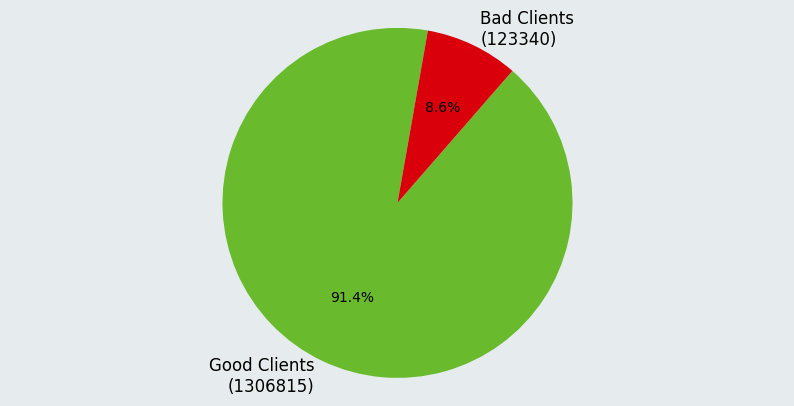

There's 1430155 Clients in our data


In [16]:
counts = train_full['TARGET'].value_counts()
fig, ax = plt.subplots(figsize=(10, 5))
fig.patch.set_facecolor('#e6ebed')
gbp = ['#69ba2d', '#d9000c']

wedges, texts, autotexts = ax.pie(counts,
                                   labels=['Good Clients', 'Bad Clients'],
                                   autopct='%1.1f%%',
                                   colors=gbp,
                                   startangle=80)

plt.axis('equal')
for i, text in enumerate(texts):
    text.set(text=texts[i].get_text() + f'\n({counts.iloc[i]})')
    texts[i].set_fontsize(12)
plt.show()
print(f"There's {train_full.shape[0]} Clients in our data")

From the plot above, we can see that:
- From total 1430155 clients in our data.
- 1,306,815 (91.4%) clients don't have payment difficulties. 
- 123,340 (8.6%) clients have payments difficulties.
- The data is highly imbalanced.

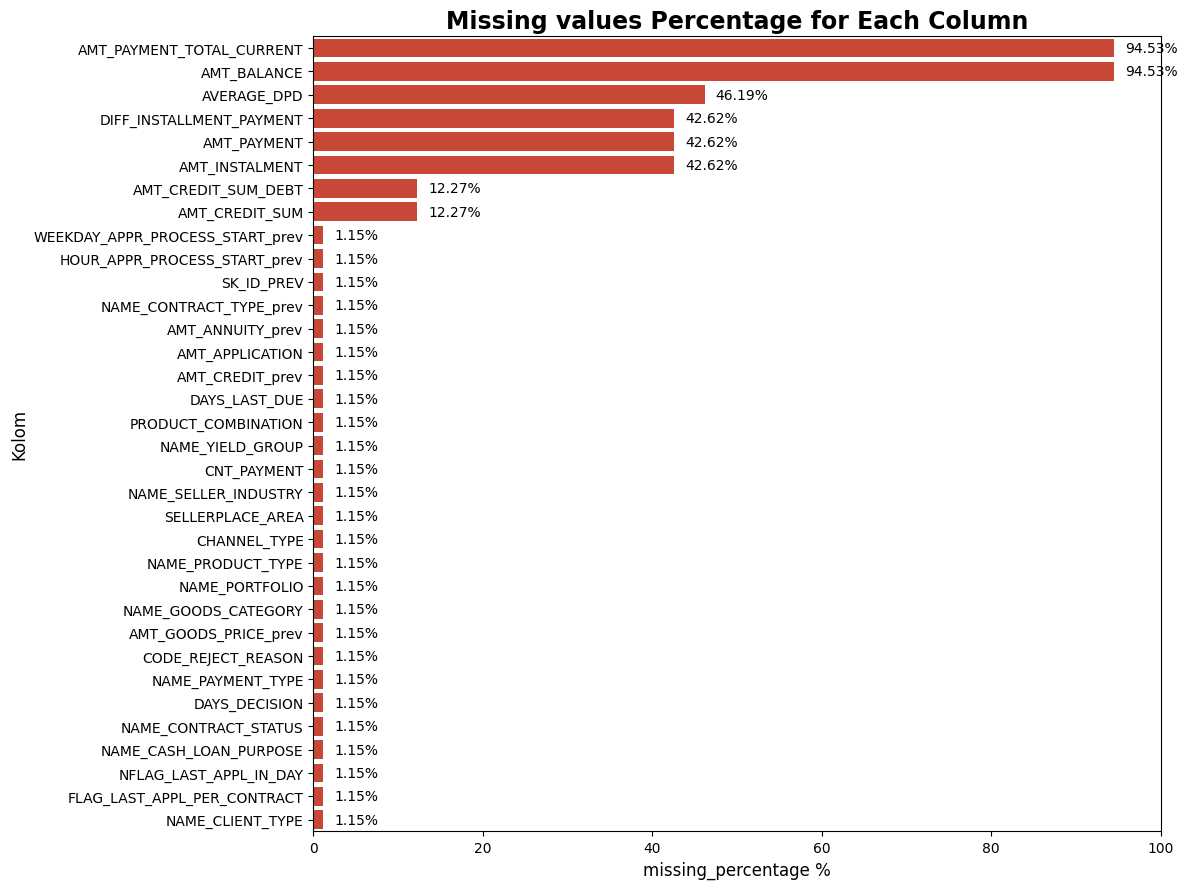

In [13]:
ms.plot_missing_percentage(train_full)

Our data Contains a lot of missing values,
- For the columns that have missing values more than 90% of the data, i will drop them.
- AVERAGE DPD missing values seems reasonable, that there's client that didn't have any DPD, or didn't have any previous application.
- for the columns `DIFF_INSTALMENT_PAYMENT`, `AMT_PAYMENT` and `AMT_INSTALMENT` i will fill the missing values with 0, because it's reasonable to assume that the client didn't have any previous application too.
- the rest of it i will leave it be, so when there's missing values, while we do woe binning, it will be treated as a separate category.

In [134]:
train_full = pd.merge(train_bureau, prev_pc, on='SK_ID_CURR', how='left', suffixes=('_curr', '_prev'))
# x train categorical value binning
train_full['AGE'] = round(abs(train_full['DAYS_BIRTH'] / 365.25)).astype(int)

train_full = train_full[train_full.NAME_FAMILY_STATUS != 'Unknown']
train_full = train_full.drop(columns=['ORGANIZATION_TYPE', 'NAME_CASH_LOAN_PURPOSE', 'CODE_REJECT_REASON', 'NAME_GOODS_CATEGORY', 
                                      'NAME_SELLER_INDUSTRY', 'PRODUCT_COMBINATION', 'NAME_GOODS_CATEGORY', 'NAME_PRODUCT_TYPE'], axis=1)

mapping_dict = {'Family' : 'Companied',
                'Spouse, partner': 'Companied',
                'Children': 'Companied',
                'Other_A': 'Companied',
                'Other_B': 'Companied',
                'Group of people': 'Companied'}
train_full = train_full.replace({'NAME_TYPE_SUITE': mapping_dict})

map_income_val = {'Unemployed': 'Others', 
                  'Student': 'Others', 
                  'Materniity leave': 'Others',
                  'Businessman': 'Others'}

train_full = train_full.replace({'NAME_INCOME_TYPE': map_income_val})

train_full = train_full.drop(columns=['SK_ID_CURR', 'SK_ID_PREV'], axis=1)

## Oulier Cheking

In [30]:
# numvisual = train_full[[
#     'CNT_CHILDREN', 'AMT_INCOME_TOTAL','AMT_CREDIT_curr', 'AMT_ANNUITY_curr',
#     'AMT_GOODS_PRICE_curr','REGION_POPULATION_RELATIVE','DAYS_BIRTH',
#     'DAYS_EMPLOYED','DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'CNT_FAM_MEMBERS',
#     'REGION_RATING_CLIENT','REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START_curr',
#     'EXT_SOURCE_2','OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE',
#     'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE',
#     'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT', 'AMT_ANNUITY_prev', 'AMT_APPLICATION',
#     'AMT_CREDIT_prev','AMT_GOODS_PRICE_prev', 'HOUR_APPR_PROCESS_START_prev',
#     'NFLAG_LAST_APPL_IN_DAY', 'DAYS_DECISION', 'SELLERPLACE_AREA',
#     'CNT_PAYMENT', 'DAYS_LAST_DUE', 'AMT_INSTALMENT', 'AMT_PAYMENT',
#     'DIFF_INSTALLMENT_PAYMENT', 'AMT_BALANCE', 'AMT_PAYMENT_TOTAL_CURRENT',
#     'AVERAGE_DPD'
#           ]].copy()

# colgroup = [numvisual.columns[n:n+4] for n in range(0, len(numvisual.columns), 4)]

# # Create a 9x4 grid of subplots
# fig, axs = plt.subplots(4, 10, figsize=(30, 15))

# # for each group of 4 columns
# for i, group in enumerate(colgroup):
#     # For eachg column in the group
#     for j, column in enumerate(group):
#         # Create a boxplot for the apporopriate subplot
#         sns.boxplot(y=numvisual[column], ax=axs[j, i ], color='blue', linewidth=1.5, orient='v')
#         axs[j, i].set_title(column)

# # show plot
# plt.tight_layout()
# plt.show()

## Train Test Split

In [10]:
X = train_full.drop(columns=['TARGET', 'SK_ID_CURR', 'SK_ID_PREV'], axis=1)
y = train_full[['TARGET']]

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1103)

## Handle Missing Values

In [11]:
# X train missing values handling
fillzero = ['AVERAGE_DPD', 'DIFF_INSTALLMENT_PAYMENT', 'AMT_PAYMENT', 'AMT_INSTALMENT']
X_train_c1 = ms.dropnan(X_train, 0.9)
X_train_c2 = X_train_c1.copy()
X_train_c2[fillzero] = X_train_c2[fillzero].fillna(0)


# train_missing = X_train_c2[X_train_c2.columns[X_train_c2.isna().any()]] 
# traincol = train_missing.columns

# for col in traincol:
#     if X_train_c2[col].dtype == 'object':
#         X_train_c2[col].fillna(X_train_c2[col].mode()[0], inplace=True)
#     else:
#         X_train_c2[col].fillna(X_train_c2[col].median(), inplace=True)


# X test missing values handling
X_test_c1 = ms.dropnan(X_test, 0.9)
X_test_c2 = X_test[fillzero].fillna(0)


# test_missing = X_test_c2[X_test_c2.columns[X_test_c2.isna().any()]]
# testcol = test_missing.columns

# for col in testcol:
#     if X_test_c2[col].dtype == 'object':
#         X_test_c2[col].fillna(X_test_c2[col].mode()[0], inplace=True)
#     else:
#         X_test_c2[col].fillna(X_test_c2[col].median(), inplace=True)

## Data filtering

In [135]:
toad.quality(train_full, target='TARGET', iv_only=True)

,iv,gini,entropy,unique
EXT_SOURCE_2,2.898664e-01,NaN,NaN,119831.0
DAYS_EMPLOYED,1.013231e-01,NaN,NaN,12574.0
AMT_GOODS_PRICE_curr,9.110960e-02,NaN,NaN,1003.0
DAYS_BIRTH,7.800352e-02,NaN,NaN,17460.0
AGE,7.753839e-02,NaN,NaN,49.0
...,...,...,...,...
NFLAG_LAST_APPL_IN_DAY,1.303514e-04,NaN,NaN,3.0
REG_REGION_NOT_LIVE_REGION,1.099248e-04,NaN,NaN,2.0
FLAG_EMAIL,6.153911e-05,NaN,NaN,2.0
FLAG_MOBIL,1.733113e-05,NaN,NaN,2.0


In [22]:
# train_selected, drop_list = toad.selection.select(frame=train_full,
#                                                   target=train_full['TARGET'],
#                                                   empty=0.5,
#                                                   iv=0.02,
#                                                   corr=0.7,
#                                                   return_drop=True)

# print(f'Number of features selected: {len(train_selected.columns)}')
# print(f'Number of features dropped: {len(drop_list)}')

In [136]:
train_selected, drop_list = toad.selection.select(frame=train_full,
                                                  target=train_full['TARGET'],
                                                  empty=0.5,
                                                  iv=0.02,
                                                  corr=0.7,
                                                  return_drop=True)

print("keep:",train_selected.shape[1],
      "drop empty:",len(drop_list['empty']),
      "drop iv:",len(drop_list['iv']),
      "drop corr:",len(drop_list['corr']))

display(train_selected)
print(f'\n{drop_list}')

keep: 23 drop empty: 2 drop iv: 40 drop corr: 6


,TARGET,CODE_GENDER,AMT_GOODS_PRICE_curr,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,REGION_RATING_CLIENT_W_CITY,REG_CITY_NOT_WORK_CITY,EXT_SOURCE_2,DAYS_LAST_PHONE_CHANGE,AMT_CREDIT_SUM_DEBT,NAME_CONTRACT_STATUS,DAYS_DECISION,CNT_PAYMENT,NAME_YIELD_GROUP,DAYS_LAST_DUE,AMT_PAYMENT,DIFF_INSTALLMENT_PAYMENT,AVERAGE_DPD
0,1,M,351000.0,Working,Secondary / secondary special,0.018801,-9461,-637,-3648.0,-2120,2,0,0.262949,-1134.0,245781.00,Approved,-606.0,24.0,low_normal,-25.0,219625.695,0.000,0.0
1,0,F,1129500.0,State servant,Higher education,0.003541,-16765,-1188,-1186.0,-291,1,0,0.622246,-828.0,0.00,Approved,-746.0,12.0,low_normal,-536.0,1150977.330,0.000,0.0
2,0,F,1129500.0,State servant,Higher education,0.003541,-16765,-1188,-1186.0,-291,1,0,0.622246,-828.0,0.00,Approved,-828.0,6.0,middle,-647.0,387113.940,0.000,0.0
3,0,F,1129500.0,State servant,Higher education,0.003541,-16765,-1188,-1186.0,-291,1,0,0.622246,-828.0,0.00,Approved,-2341.0,12.0,middle,-1980.0,80773.380,0.000,0.0
4,0,M,135000.0,Working,Secondary / secondary special,0.010032,-19046,-225,-4260.0,-2531,2,0,0.555912,-815.0,0.00,Approved,-815.0,4.0,middle,-724.0,21288.465,0.000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1430150,0,F,675000.0,Commercial associate,Higher education,0.046220,-16856,-1262,-5128.0,-410,1,1,0.708569,-787.0,1534913.01,Approved,-648.0,24.0,middle,-558.0,282631.905,32801.220,0.0
1430151,0,F,675000.0,Commercial associate,Higher education,0.046220,-16856,-1262,-5128.0,-410,1,1,0.708569,-787.0,1534913.01,Refused,-456.0,0.0,XNA,0.0,NaN,NaN,NaN
1430152,0,F,675000.0,Commercial associate,Higher education,0.046220,-16856,-1262,-5128.0,-410,1,1,0.708569,-787.0,1534913.01,Refused,-171.0,60.0,low_normal,0.0,NaN,NaN,NaN
1430153,0,F,675000.0,Commercial associate,Higher education,0.046220,-16856,-1262,-5128.0,-410,1,1,0.708569,-787.0,1534913.01,Approved,-787.0,36.0,low_normal,-66.0,2251553.805,-559292.895,0.0



{'empty': array(['AMT_BALANCE', 'AMT_PAYMENT_TOTAL_CURRENT'], dtype='<U25'), 'iv': array(['NAME_CONTRACT_TYPE_curr', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'NAME_TYPE_SUITE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'FLAG_MOBIL',
       'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL',
       'CNT_FAM_MEMBERS', 'WEEKDAY_APPR_PROCESS_START_curr',
       'HOUR_APPR_PROCESS_START_curr', 'REG_REGION_NOT_LIVE_REGION',
       'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION',
       'REG_CITY_NOT_LIVE_CITY', 'LIVE_CITY_NOT_WORK_CITY',
       'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE',
       'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE',
       'AMT_CREDIT_SUM', 'NAME_CONTRACT_TYPE_prev', 'AMT_ANNUITY_prev',
       'AMT_APPLICATION', 'AMT_CREDIT_prev', 'AMT_GOODS_PRICE_prev',
       'WEEKDAY_APPR_PROCESS_START_prev', 'HOUR_APPR_PROCESS_START_prev',
       'FLAG_LAST_APPL_PER_CONTRACT', 'NFLAG_LAS

In [137]:
# train_selected, drop_list = toad.selection.select(frame=train_full,
#                                                   target=train_full['TARGET'],
#                                                   empty=0.5,
#                                                   iv=0.02,
#                                                   corr=0.7,
#                                                   return_drop=True)

# print("keep:",train_selected.shape[1],
#       "drop empty:",len(drop_list['empty']),
#       "drop iv:",len(drop_list['iv']),
#       "drop corr:",len(drop_list['corr']))

# display(train_selected)
# print(f'\n{drop_list}')

In [138]:
# output the iv table to a dataframe
def iv_importance(data_selected, label):
    iv_import_feat = toad.quality(data_selected, label, iv_only=True)
    iv_import_feat = iv_import_feat['iv']
    iv_import_feat = iv_import_feat.reset_index()
    iv_import_feat.columns = ['name', 'iv']
    return iv_import_feat

df_iv = iv_importance(train_selected, 'TARGET')

In [139]:
df_iv.sort_values(by='iv', ascending=False)

,name,iv
0,EXT_SOURCE_2,0.289866
1,DAYS_EMPLOYED,0.101323
2,AMT_GOODS_PRICE_curr,0.091110
3,DAYS_BIRTH,0.078004
4,AMT_CREDIT_SUM_DEBT,0.069500
5,NAME_INCOME_TYPE,0.057056
6,DAYS_LAST_PHONE_CHANGE,0.056691
7,REGION_RATING_CLIENT_W_CITY,0.045908
8,REGION_POPULATION_RELATIVE,0.042007
9,NAME_CONTRACT_STATUS,0.040772


## Feature Binning

In [141]:
# intialize toad transformer
c = toad.transform.Combiner()

# fit the transformer
c.fit(X=train_selected, y='TARGET', method='chi', min_samples=0.5, n_bins=10, empty_separate=True)

KeyboardInterrupt: 

In [ ]:
from toad.plot import bin_plot

## Handling Outlier

In [38]:
def cap_outliers(data, columns):
    # Create a copy of the data to avoid modifying the original DataFrame
    result = data.copy()

    # Loop over each column in the provided list
    for col in columns:
        # Calculate the first quartile (Q1) for the current column
        Q1 = result[col].quantile(0.25)
        # Calculate the third quartile (Q3) for the current column
        Q3 = result[col].quantile(0.75)
        # Calculate the Interquartile Range (IQR) for the current column
        IQR = Q3 - Q1
        # Calculate the lower bound for the current column
        lower_bound = Q1 - (1.5 * IQR)
        # Calculate the upper bound for the current column
        upper_bound = Q3 + (1.5 * IQR)
        # Replace values in the current column that are less than the lower bound with the lower bound
        result[col] = np.where(result[col] < lower_bound, lower_bound, result[col])
        # Replace values in the current column that are greater than the upper bound with the upper bound
        result[col] = np.where(result[col] > upper_bound, upper_bound, result[col])
    # Return the DataFrame with capped outliers
    return result

In [39]:
# Select the names of all numerical columns in the DataFrame X_train_c2
outliers = X_train_c2.select_dtypes(include='number').columns

# Call the cap_outliers function on X_train_c2, passing in the names of the numerical columns
# This will cap the outliers in these columns, and the result is stored in X_train_c3
X_train_c3 = cap_outliers(X_train_c2, outliers)

## Feature Engineering

In [40]:
# x train categorical value binning
X_train_c3['AGE'] = round(abs(X_train_c3['DAYS_BIRTH'] / 365.25)).astype(int)

X_train_c3 = X_train_c3[X_train_c3.NAME_FAMILY_STATUS != 'Unknown']
y_train = y_train.drop([194676, 868956])
X_train_c3 = X_train_c3.drop(columns=['ORGANIZATION_TYPE', 'NAME_CASH_LOAN_PURPOSE', 'CODE_REJECT_REASON', 'NAME_GOODS_CATEGORY', 
                                      'NAME_SELLER_INDUSTRY', 'PRODUCT_COMBINATION'], axis=1)

mapping_dict = {'Family' : 'Companied',
                'Spouse, partner': 'Companied',
                'Children': 'Companied',
                'Other_A': 'Companied',
                'Other_B': 'Companied',
                'Group of people': 'Companied'}
X_train_c3 = X_train_c3.replace({'NAME_TYPE_SUITE': mapping_dict})

map_income_val = {'Unemployed': 'Others', 
                  'Student': 'Others', 
                  'Materniity leave': 'Others',
                  'Businessman': 'Others'}

X_train_c3 = X_train_c3.replace({'NAME_INCOME_TYPE': map_income_val})


# x test categorical value binning
X_test_c3 = X_test_c2.copy()
X_test_c3['AGE'] = round(abs(X_test_c3['DAYS_BIRTH'] / 365.25)).astype(int)

X_test_c3 = X_test_c3[X_test_c3.NAME_FAMILY_STATUS != 'Unknown']
X_test_c3 = X_test_c3.drop(columns=['ORGANIZATION_TYPE', 'NAME_CASH_LOAN_PURPOSE', 'CODE_REJECT_REASON', 'NAME_GOODS_CATEGORY', 
                                    'NAME_SELLER_INDUSTRY', 'PRODUCT_COMBINATION'], axis=1)

X_test_c3 = X_test_c3.replace({'NAME_TYPE_SUITE': mapping_dict})
X_test_c3 = X_test_c3.replace({'NAME_INCOME_TYPE': map_income_val})

## Feature Encoding

In [17]:
from sklearn.preprocessing import LabelEncoder

# Create a LabelEncoder object
le = LabelEncoder()

X_train_c4 = X_train_c3.copy()
# Iterate over all values of each column and extract their dtypes
for col in X_train_c4.columns:
    # Compare if the dtype is object
    if X_train_c4[col].dtype == 'object':
    # Use LabelEncoder to do the numeric transformation
        X_train_c4[col] = le.fit_transform(X_train_c4[col])
        X_test_c3[col] = le.fit_transform(X_test_c3[col])

In [41]:
# one hot encoding all categorical columns
X_train_c4 = pd.get_dummies(X_train_c3, drop_first=True).astype(int)
X_test_c4 = pd.get_dummies(X_test_c3, drop_first=True).astype(int)

## Feature Scaling

In [42]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train_c4)

X_test_scaled = scaler.transform(X_test_c4)

## Handle Imbalance data

In [27]:
stomek = SMOTETomek(random_state=1103)
X_over, y_over = stomek.fit_resample(X_train_scaled, y_train)

In [ ]:
counts = y_over['TARGET'].value_counts()
fig, ax = plt.subplots(figsize=(10, 5))
fig.patch.set_facecolor('#e6ebed')
gbp = ['#69ba2d', '#d9000c']

wedges, texts, autotexts = ax.pie(counts,
                                   labels=['Good Clients', 'Bad Clients'],
                                   autopct='%1.1f%%',
                                   colors=gbp,
                                   startangle=80)

plt.axis('equal')
for i, text in enumerate(texts):
    text.set(text=texts[i].get_text() + f'\n({counts.iloc[i]})')
    texts[i].set_fontsize(12)
plt.show()

## Model Building

In [46]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    # Fit the model to the training data
    model.fit(X_train, y_train)
    
    # Make predictions on the training data
    y_train_pred = model.predict(X_train)
    
    # Make predictions on the testing data
    y_test_pred = model.predict(X_test)
    
    # Calculate the accuracy for the training and testing data
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    
    # Calculate the precision for the training and testing data
    train_precision = precision_score(y_train, y_train_pred)
    test_precision = precision_score(y_test, y_test_pred)
    
    # Calculate the recall for the training and testing data
    train_recall = recall_score(y_train, y_train_pred)
    test_recall = recall_score(y_test, y_test_pred)
    
    # Calculate the F1 score for the training and testing data
    train_f1 = f1_score(y_train, y_train_pred)
    test_f1 = f1_score(y_test, y_test_pred)

    # Calculate the ROC AUC for the training and testing data
    train_roc_auc = roc_auc_score(y_train, y_train_pred)
    test_roc_auc = roc_auc_score(y_test, y_test_pred)
    
    return {
        'model': model.__class__.__name__,
        'train_recall': round(train_recall, 2),
        'test_recall': round(test_recall, 2),
        'train_roc_auc': round(train_roc_auc, 2),
        'test_roc_auc': round(test_roc_auc, 2)
    }

In [60]:
# import xgboost model
from xgboost import XGBClassifier

# import gradient boosting model
from sklearn.ensemble import GradientBoostingClassifier

lr = LogisticRegression(random_state=1103, class_weight='balanced')
xgb = XGBClassifier(random_state=1103)
gbc = GradientBoostingClassifier(random_state=1103)

models = [lr, xgb]

results = [evaluate_model(model, X_train_scaled, y_train, X_test_scaled, y_test) for model in models]

# Convert the results to a DataFrame
df_model = pd.DataFrame(results)

In [61]:
df_model

,model,train_recall,test_recall,train_roc_auc,test_roc_auc
0,LogisticRegression,0.64,0.65,0.64,0.58
1,XGBClassifier,0.07,0.06,0.53,0.53


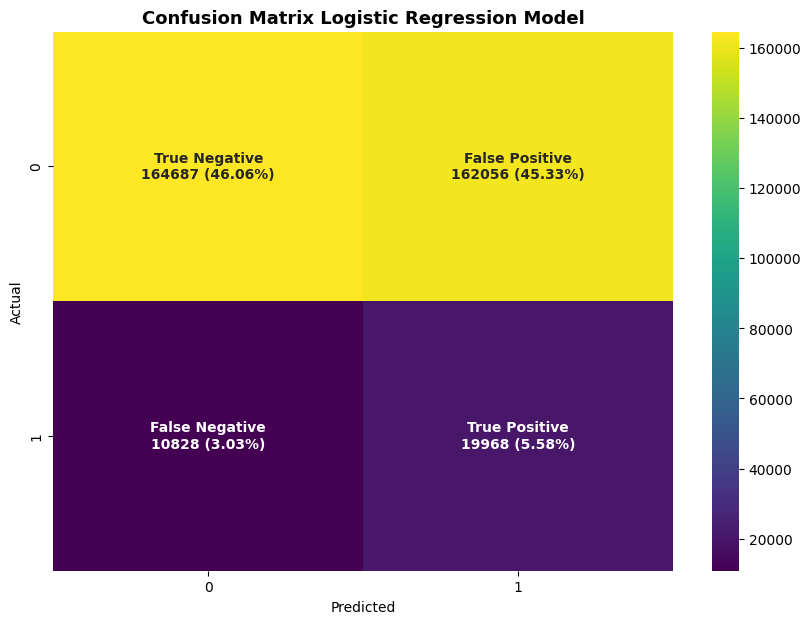

In [53]:
# Assuming X_test is your test dataset and model is your Gradient Boosting model
y_pred = lr.predict(X_test_scaled)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Calculate the percentage of each category
percentage_matrix = cnf_matrix / cnf_matrix.sum()

# Define the labels
labels = np.array([['True Negative', 'False Positive'],
                   ['False Negative', 'True Positive']])

# Create labels with both count and percentage
new_labels = (np.asarray(["{0}\n{1} ({2:.2%})".format(label, value, percentage)
                          for label, value, percentage in zip(labels.flatten(), cnf_matrix.flatten(), percentage_matrix.flatten())])
             ).reshape(2,2)

# Plot confusion matrix using a heatmap
fig = plt.figure(figsize=(10,7))
fig.patch.set_facecolor('white')  # Change figure color

sns.heatmap(cnf_matrix, annot=new_labels, fmt='', cmap='viridis', annot_kws={"weight": "bold"})
plt.title('Confusion Matrix Logistic Regression Model', fontsize=13, fontweight='bold')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Change label colors
plt.gca().xaxis.label.set_color('black')
plt.gca().yaxis.label.set_color('black')

plt.show()

## WoE and IV

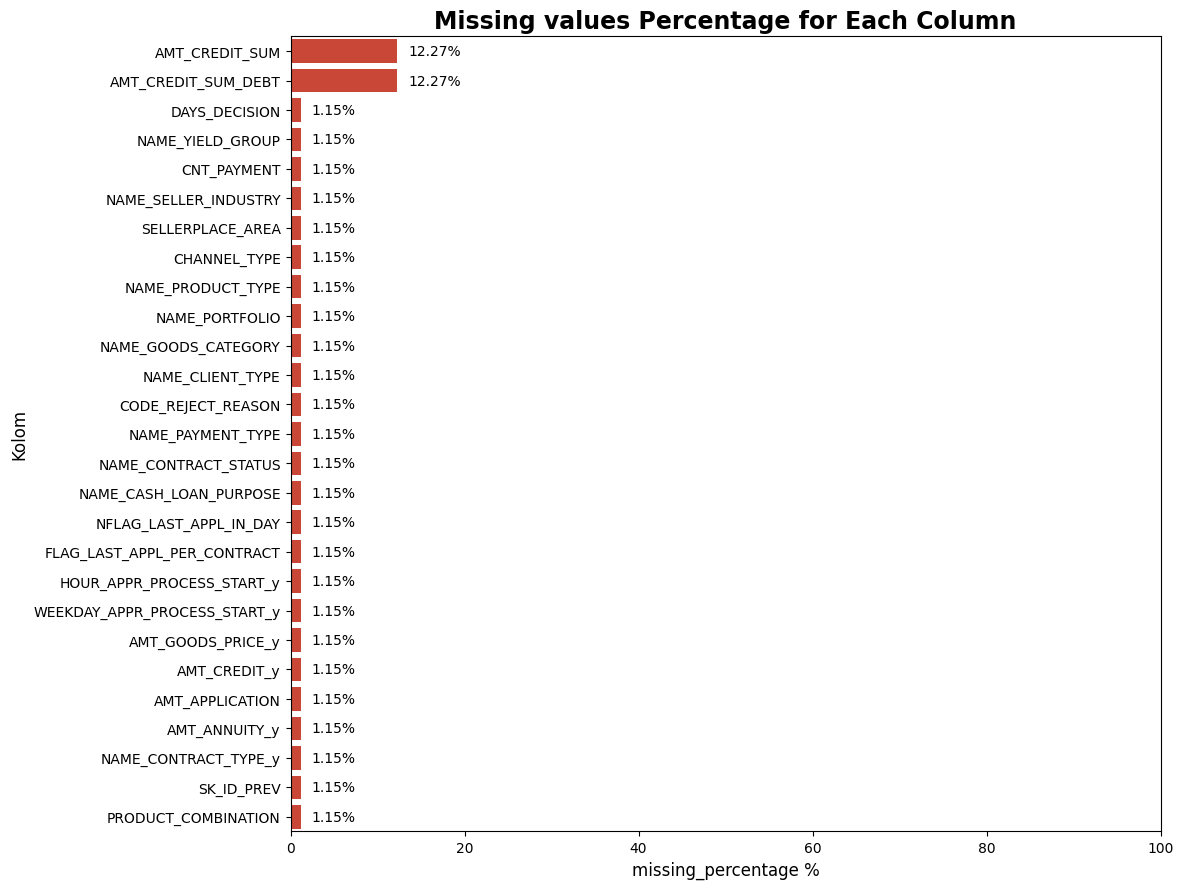

In [ ]:
ms.plot_missing_percentage(train_clean2)